In [1]:
import os
os.chdir('../src')

In [2]:
import logging, datetime
from pathlib import Path
import torch
import pandas as pd

from datasets import create_train_loader, create_valid_loader
from datasets.train_dataset import trainMammo
from datasets.transforms import get_train_transform
from configs import cfg
from modeling.model import kaggleBCModel
from engine.fitter import Fitter

import matplotlib.pyplot as plt

In [3]:
path_df = os.path.join(
        cfg.INPUT.ROOT_DIR, 'train_folds.csv'
    )

df = pd.read_csv(
    path_df
)


train_df = df[df['fold'] != cfg.INPUT.VALID_FOLD].sample(frac=0.01)
valid_df = df[df['fold'] == cfg.INPUT.VALID_FOLD].sample(frac=0.01)

model = kaggleBCModel(
    aux_class=train_df[cfg.INPUT.AUX_TARGETS].max()+1,
    cfg = cfg
)

In [4]:
trns = get_train_transform(cfg)
train_ds = trainMammo(cfg, train_df, transforms = trns)

train_loader = create_train_loader(cfg, df=train_df)
valid_loader = create_valid_loader(cfg, df=valid_df)
#model = kaggleBCModel(cfg)

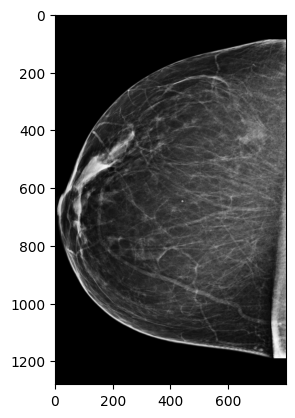

In [5]:
img = train_ds[1][0]
plt.imshow(img.permute(1,2,0))

In [6]:
#Istanzio il logger
Path(cfg.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

#Istanzio il logger
path_logger = os.path.join(
    cfg.OUTPUT_DIR, f'train-{datetime.datetime.now()}.log'
)

logging.basicConfig(filename=path_logger, level=logging.DEBUG)
logger = logging.getLogger()

In [7]:
import neptune.new as neptune

run = neptune.init_run(
    project="geno/rsna-mammo-kaggle",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMjA5NDA5Zi1kYTdhLTQ5MGMtOTU4Ni02ODU0YmJkNTdlNDQifQ==",
)

run['parameters'] = cfg

https://app.neptune.ai/geno/rsna-mammo-kaggle/e/RSNAM-41
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/home/giorgio/Scrivania/kaggle/rnsa-mammo-kaggle/env/lib/python3.8/site-packages/neptune/new/attributes/attribute.py:64: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  return self.assign(value, wait)


In [8]:
fit_engine = Fitter(
    model,
    cfg,
    train_loader,
    valid_loader,
    logger,
    run
)

In [9]:
fit_engine.fit()

Training:   0%|          | 0/142 [00:00<?, ?it/s]MIOpen(HIP): Warning [SQLiteBase] Unable to read system database file:gfx900_64.kdb Performance may degrade
Train Step 141/142, Learning rate 0.0001, summary_loss: 8.94726, cancer_loss: 0.57063, aux_loss: 1.04708, time: 142.38434: 100%|██████████| 142/142 [02:22<00:00,  1.00s/it]
Validate Step 26/27, Validation loss 8.29558, Validation cancer_loss 0.38602, Validation aux_loss 0.98869, time: 18.17247Best score found: 0.0000: 100%|██████████| 27/27 [00:18<00:00,  1.49it/s]


Best score found at AUC 0.6367924528301887: 0.08163265306122448 with threshold 0.29
Best score found: fbeta 0.0816


Train Step 141/142, Learning rate 9e-05, summary_loss: 7.42158, cancer_loss: 0.42928, aux_loss: 0.87404, time: 94.13309: 100%|██████████| 142/142 [01:34<00:00,  1.51it/s]
Validate Step 26/27, Validation loss 7.83502, Validation cancer_loss 0.26638, Validation aux_loss 0.94608, time: 5.30856Best score found: 0.0816: 100%|██████████| 27/27 [00:05<00:00,  5.15it/s]


Best score found at AUC 0.5330188679245284: 0.05479452054794521 with threshold 0.07


Train Step 141/142, Learning rate 8.1e-05, summary_loss: 6.81826, cancer_loss: 0.31428, aux_loss: 0.81300, time: 94.06870: 100%|██████████| 142/142 [01:34<00:00,  1.51it/s]
Validate Step 26/27, Validation loss 7.76749, Validation cancer_loss 0.41670, Validation aux_loss 0.91885, time: 5.31650Best score found: 0.0816: 100%|██████████| 27/27 [00:05<00:00,  5.14it/s]


Best score found at AUC 0.6179245283018868: 0.08333333333333334 with threshold 0.29


Train Step 8/142, Learning rate 7.290000000000001e-05, summary_loss: 6.63124, cancer_loss: 0.29609, aux_loss: 0.79189, time: 6.06575:   6%|▋         | 9/142 [00:06<01:40,  1.32it/s]


KeyboardInterrupt: 